# 1st Order Quality Check of DAS Data

This script should do a 1st ordder quality check of the DAS data. That means, that it will look for potential data gaps, recording issues, data saturation, etc... Before running this script, look into the script DAS_QC1_datacoverage to see obvious data gaps.

In [1]:
# load modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import scipy
import os
import pandas as pd
import sys
import DASfuncs
import matplotlib.dates as mdates

In [41]:
# get all hdf5 file names from given directory
path = '../../../data/lab/*h5'
path = '/Users/graeffd/tmp/Samsung_2TB/ManualRecorders/data_2kiloHz/decimator_2023-07-06_23.40.53_UTC.h5'
files = glob.glob(path)
files.sort()
print('{} files in directory'.format(len(files)))

2 files in directory


In [42]:
# select a file
file = files[0]
print(file)

../../../data/lab/decimator_2023-05-17_17.42.24_UTC.h5


In [43]:
# read data of a single file and store in memory
f = h5py.File(file,'r')
data_rec = np.array(f['Acquisition/Raw[0]/RawData'])
attrs = dict(f['Acquisition'].attrs)
t_rec = np.array(f['Acquisition/Raw[0]/RawDataTime'])
times_rec = DASfuncs.sintela_to_datetime(t_rec)

First look into the distribution of time samples. Good quality data should be regularly sampled. Therefore the following plot should be a straight line. If it has some peaks, data gaps are present.

# Data Gaps

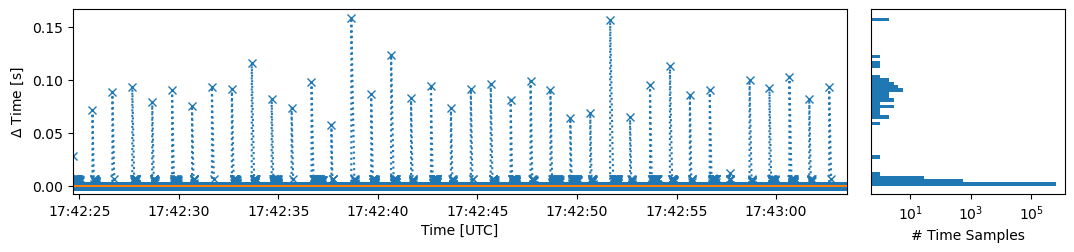

In [44]:
%matplotlib inline
# plot time difference between samples
dt = np.diff(t_rec)/1e6

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6.4*2,4.8/2.), width_ratios=[4, 1])
ax0.plot(times_rec[:-1], dt, linestyle='dotted', marker='x')
ax0.hlines(1/attrs['PulseRate'], times_rec[0], times_rec[-1], color='C1')
ax0.set_ylabel(r'$\Delta$ Time [s]')
ax0.set_xlabel('Time [UTC]')
ax0.set_xlim(times_rec[0], times_rec[-1])

ax1.hist(dt, bins=50, orientation='horizontal')
ax1.set_xscale('log')
ax1.set_xlabel('# Time Samples')
ax1.set_yticks([])

plt.subplots_adjust(wspace=0.05)

If there are data gaps present, ie. the time samples are not equally spaced, we have to add these data gaps to the ```data``` array.

In [45]:
# fill contiuous parts of data into array
time_list, data_list = DASfuncs.split_continuous_data(t_rec, data_rec, attrs)
# fill data gaps in array
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, data_list, attrs, t_format='datetime')
print('Data filles {:.2} GB of memory.'.format(sys.getsizeof(data_filled)/2**30))

Data filles 2.3 GB of memory.


In [46]:
nt = data_filled.shape[0]
nx = data_filled.shape[1]
print('Number of time steps: {}, Number of channels: {}'.format(nt,nx))
print("Sampling Frequency: {} Hz, cable length: {:.1f} m".format(attrs['PulseRate'], attrs['SpatialSamplingInterval']*nx))

Number of time steps: 777180, Number of channels: 391
Sampling Frequency: 20000.0 Hz, cable length: 623.7 m


## Raw Data Waterfall

Let's have a first look into the data! But careful! Some small data gaps might not be visible in the above plot, because of aliasing.

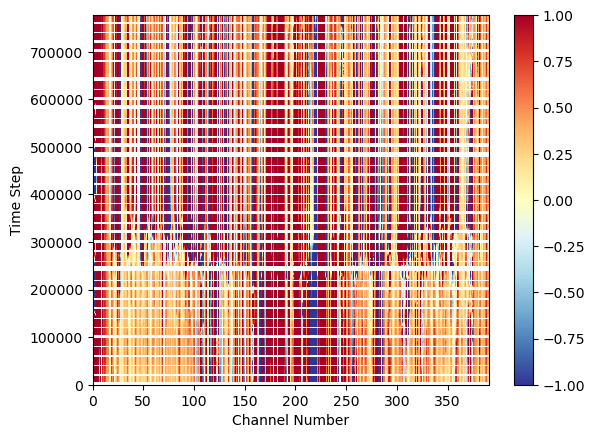

In [47]:
%matplotlib inline
# plot the raw data including data gaps
import matplotlib
cmap = plt.get_cmap('RdYlBu_r')
cmap.set_bad(color='white')
fig, ax = plt.subplots()
im = ax.imshow(data_filled, aspect='auto', vmin=-1,vmax=1, 
               extent=[attrs['StartLocusIndex'],
                       attrs['StartLocusIndex']+nx
                      ,0,len(times_filled)], 
               cmap=cmap, origin='lower',
               # interpolation='none'
              )
cbar = plt.colorbar(im)
plt.xlabel('Channel Number')
plt.ylabel('Time Step')
plt.show()

For larger cable lengths, it might be helpful to only look into a subset. For GreenFjord, this might be the part of the cable which is actually under water.

### Select Data to have a closer look!!!

In [59]:
# select channels to look into (exclude bad channels in which we are not interested)
start_cha = 0 
end_cha = 50#nx
t_start = 0 # in seconds
t_end = nt/attrs['PulseRate'] # in seconds

data_select = data_filled[int(t_start*attrs['PulseRate']):int(t_end*attrs['PulseRate'])
                   ,start_cha:end_cha]

## Histogram of Data

Let's look into the distribution of the measured values. The measurement is in units of phase (rad). The interrogator works best, if there are no phase jumps (values larger than 1) present.

58% of selected not-NaN data with phase between +/- 1


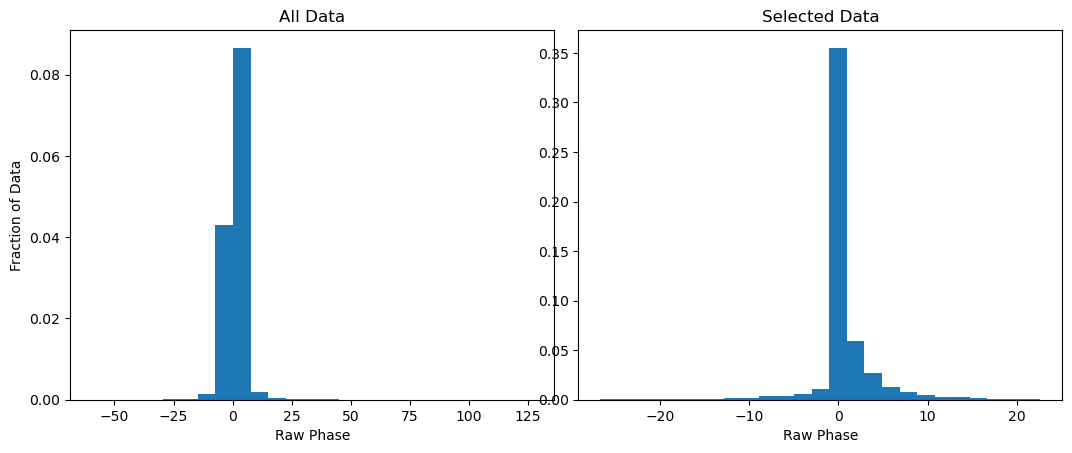

In [60]:
# plot distribution of raw phase. Should be between -1 and +1
fig, ax = plt.subplots(1,2, figsize=(2*6.4,4.8))
ax[0].hist(data_rec.flatten(), bins=25, density=True)
ax[1].hist(data_select.flatten(), bins=25, density=True)
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
ax[0].set_ylabel('Fraction of Data')
ax[0].set_xlabel('Raw Phase')
ax[1].set_xlabel('Raw Phase')
ax[0].set_title('All Data')
ax[1].set_title('Selected Data')
plt.subplots_adjust(wspace=0.05)

len_valid = len((data_select[np.abs(data_select)<1.]).flatten())
len_all = len(data_select.flatten())
print('{:.0f}% of selected not-NaN data with phase between +/- 1'.format(100*len_valid/len_all))

## Time Series of Channels

Here we take a look into the time series of some channels. For comparing the channels with each other, we first normalize each channel by its peak amplitude.

In [61]:
# normalize each channel by the maximum amplitude
data_norm = data_select.copy()
data_norm -= np.mean(data_norm[~np.isnan(data_norm)], axis=0)
data_norm = data_norm / (np.max(data_norm[~np.isnan(data_norm)], axis=0) - np.min(data_norm[~np.isnan(data_norm)], axis=0))

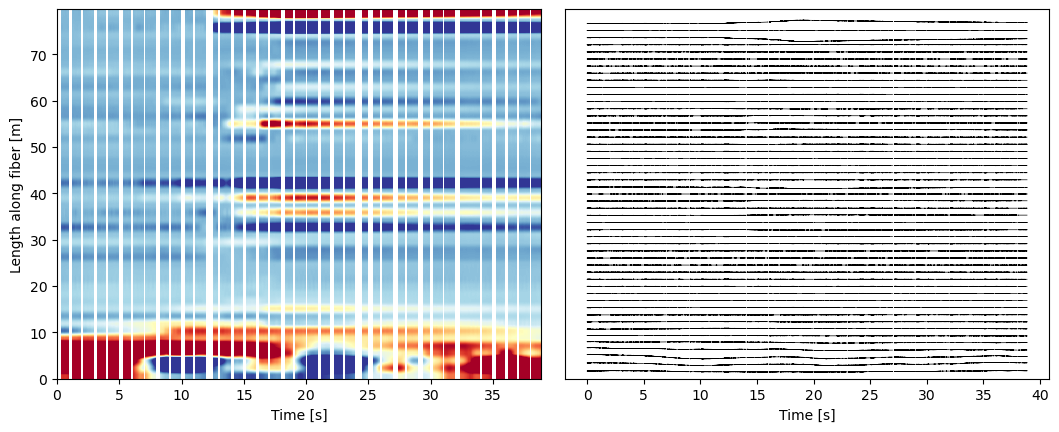

In [62]:
%matplotlib inline
# plot the selected data as image and as traces
fig, ax = plt.subplots(1,2, figsize=(2*6.4,4.8))

# left plot
ax[0].imshow(data_norm.T, origin='lower',
           aspect='auto',vmin=np.percentile(data_norm[~np.isnan(data_norm)],5),
             vmax=np.percentile(data_norm[~np.isnan(data_norm)],95),
           extent=[t_start,t_end,
                   start_cha*attrs['SpatialSamplingInterval'],
                   end_cha*attrs['SpatialSamplingInterval']],
            cmap='RdYlBu_r',
            # interpolation='none'
            )
# right plot
t_axis = np.arange(t_start, t_end, 1/attrs['PulseRate'])
for i in range(0, np.shape(data_select)[1], 1):
    ax[1].plot(t_axis, start_cha+i+data_norm[:,i], linestyle='-', color='k', alpha=1, linewidth=0.5)
    
ax[0].set_ylabel('Length along fiber [m]')
ax[1].set_yticks([])
ax[0].set_xlabel('Time [s]')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylim(start_cha-1, np.shape(data_select)[1]+1)
plt.subplots_adjust(wspace=0.05)
plt.show()

## Individual Channel Time Series

In [63]:
# select also channels from data list
data_list_select = [data[int(t_start*attrs['PulseRate']):int(t_end*attrs['PulseRate'])
                   ,start_cha:end_cha] for data in data_list]

In [64]:
# filtering
sos = scipy.signal.butter(2, (10,100),'bandpass', fs=attrs['PulseRate'], output='sos') # frequency in m
filt_list = [DASfuncs.apply_sosfiltfilt_with_nan(sos, arr, axis=0) for arr in data_list_select]

Text(0.5, 0, 'Time')

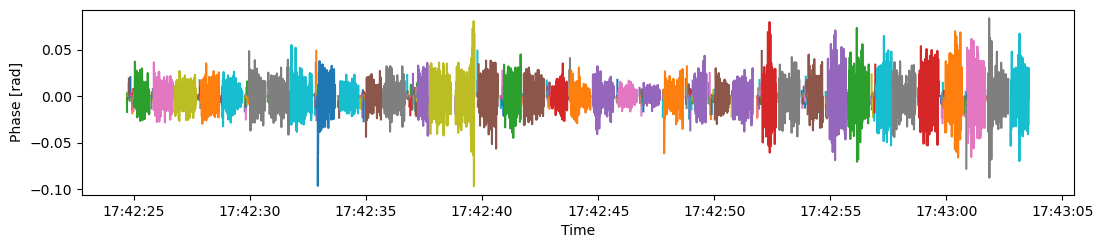

In [65]:
# plot filtered time series
%matplotlib inline
cha = 0

fig, ax = plt.subplots(figsize=(2*6.4,4.8/2.))
for t, d in zip(time_list, filt_list):
    # plt.plot(t,d[:,cha])
    # the convertion to datatime takes long...
    t_plot = DASfuncs.sintela_to_datetime(t)
    ax.plot(t_plot,d[:,cha]) # with datetime formatting
    # ax.plot(t_plot, np.mean(d, axis=1), color='k')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel('Phase [rad]')
ax.set_xlabel('Time')

## Spectrogram

Let's look into a spectrogram

Text(0.5, 0, 'Time [s]')

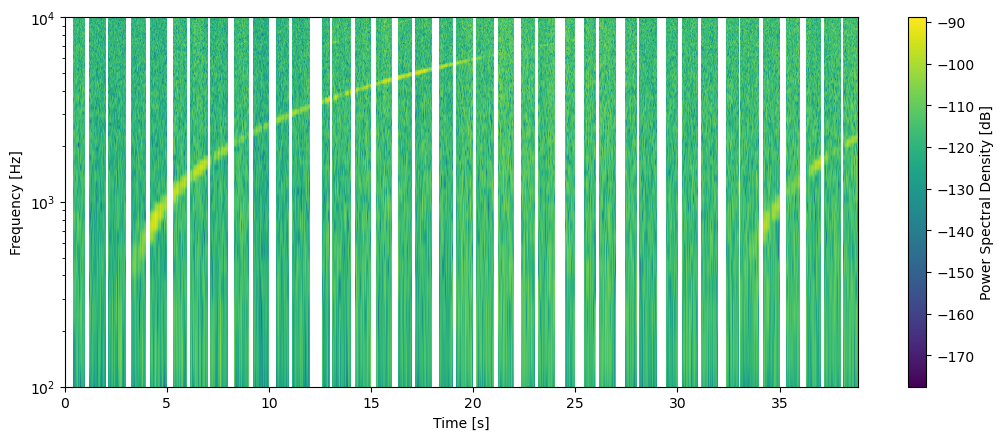

In [67]:
# plot a spectrogram of the median signal
%matplotlib inline
spec_data = np.nanmedian(data_norm, axis=1)

fs = attrs['PulseRate'] #sampling rate
NFFT = fs*0.01
fig, ax = plt.subplots(figsize=(2*6.4,4.8))
Pxx, freqs, bins, im = ax.specgram(spec_data, 
                                    Fs=fs,
                                    NFFT=int(NFFT),
                                    noverlap=0,
                                    detrend='linear',   # detrending before taking fourier transform
                                    mode='psd',         # 'psd', 'magnitude', 'angle', 'phase'
                                    scale_by_freq=True, # unit/Hz
                                    scale='dB',
                                    # vmax=-40, vmin=-80
                                   )

cbar = plt.colorbar(im)
cbar.set_label('Power Spectral Density [dB]') #colorbar label
ax.set_ylim(fs/NFFT,fs/2)
ax.set_yscale('log')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')

## Spectra of Channels

In [68]:
# plot a periodogram for each channel by using the pyplot.specgram function 
# because it handles data gaps easily
fs = attrs['PulseRate'] #sampling rate
NFFT = 2048*4#int(fs*0.1)
print(NFFT)

NFFT/2+1
Pxx_all = np.full([np.shape(data_select)[1],int(NFFT/2+1)], np.nan)
freqs_all = np.full([np.shape(data_select)[1],int(NFFT/2+1)], np.nan)
for i in range(np.shape(data_select)[1]):
    # calculates spectra
    Pxx, freqs, bins, im = plt.specgram(data_select[:,i], Fs=fs, NFFT=NFFT)
    plt.close()
    if not np.isnan(Pxx).all():
        Pxx_mean = np.nanmean(Pxx, axis=1)
        Pxx_all[i,:] = Pxx_mean
        freqs_all[i,:] = freqs
    else:
        continue

8192


Text(0.5, 0, 'Channel Number')

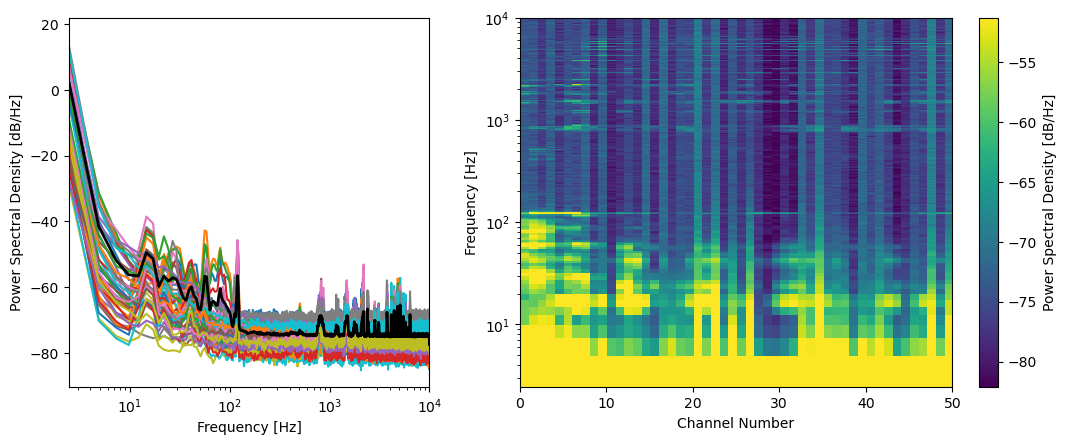

In [69]:
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(2*6.4,4.8), width_ratios=[1,1.5])
# left plot
ax[0].plot(freqs_all.T, 10*np.log10(Pxx_all.T))
ax[0].plot(np.mean(freqs_all, axis=0), 10*np.log10(np.mean(Pxx_all, axis=0)), color='k', linewidth=2)
ax[0].set_xscale('log')
ax[0].set_xlim(fs/NFFT,fs/2)
ax[0].set_ylabel('Power Spectral Density [dB/Hz]')
ax[0].set_xlabel('Frequency [Hz]')

# right plot
im = ax[1].imshow(10*np.log10(Pxx_all).T, origin='lower', aspect='auto',
             vmin=np.percentile(10*np.log10(Pxx_all),1),
             vmax=np.percentile(10*np.log10(Pxx_all),99.9),
             extent=[attrs['StartLocusIndex'],attrs['StartLocusIndex']+data_select.shape[1],
                    np.min(np.mean(freqs_all, axis=0)), np.max(np.mean(freqs_all, axis=0))],
             cmap='viridis',
             # interpolation='none'
                 )
cbar = plt.colorbar(im)
cbar.set_label('Power Spectral Density [dB/Hz]') #colorbar label
ax[1].set_yscale('log')
ax[1].set_ylim(fs/NFFT,fs/2)
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Channel Number')

In [ ]:
attrs